In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read in the data
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')

# Sample the data to speed up computation
# Comment out this line to match with lecture
df = df.sample(frac=0.1, random_state=10)

df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0


In [3]:
# df = df.dropna()
df = df[df['Rating']!=3]

In [4]:
df['Positively_rated'] = np.where(df['Rating']>3 ,1, 0)
# Encode 4s and 5s as 1 (rated positively)
# Encode 1s and 2s as 0 (rated poorly)

In [5]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Positively_rated
394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0,1
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0,0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0,1
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0,0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0,1


In [6]:
df = df[['Positively_rated', 'Reviews']]


In [7]:
df = df.dropna()

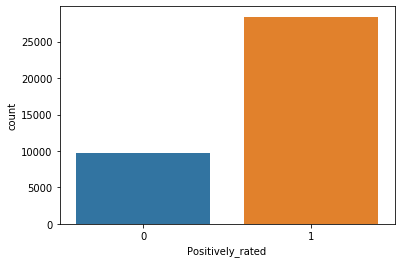

In [8]:
import seaborn as sns
sns.countplot(df['Positively_rated']);

In [9]:
sentence = 'Hey! How are you? How is your studies going?'

In [10]:
import nltk
from nltk.corpus import stopwords
import string

def text_process(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = nltk.word_tokenize(text)
    text = [char for char in text if char.lower() not in stopwords.words('English')]
#     text = [char.lower() for char in text if len(char) > 3]
    return text

In [11]:
df['Reviews'][:2].apply(text_process)

394349    [good, one, Better, Samsung, iphones, Quality,...
34377         [phone, needed, SIM, card, would, nice, know]
Name: Reviews, dtype: object

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Positively_rated'], test_size=0.25, random_state=0)

In [13]:
print('X_train first entry:\n\n', X_train.iloc[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 Great


X_train shape:  (28631,)


# CountVectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
bow = CountVectorizer().fit(X_train)

In [16]:
bow.get_feature_names()[::2000]

['00',
 'anyon',
 'certainly',
 'device2',
 'figo',
 'igualmente',
 'many',
 'param',
 'refined',
 'socializing',
 'troublesome']

In [17]:
len(bow.get_feature_names())

21879

In [18]:
X_train_vect = bow.transform(X_train)
X_test_vect = bow.transform(X_test)

In [19]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=20000)
model.fit(X_train_vect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
lnpred = model.predict(X_test_vect)
from sklearn.metrics import classification_report
print(classification_report(y_test, lnpred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2411
           1       0.95      0.96      0.96      7133

    accuracy                           0.94      9544
   macro avg       0.92      0.91      0.91      9544
weighted avg       0.94      0.94      0.94      9544



In [21]:
from sklearn.metrics import roc_auc_score
print('AUC: ', roc_auc_score(y_test, lnpred))

AUC:  0.909815915104279


In [22]:
features = np.array(bow.get_feature_names())

In [23]:
sorted_coeff = model.coef_[0].argsort()


In [24]:
negative_class_coeff = features[sorted_coeff[:10]]
positive_class_coeff = features[sorted_coeff[-10:]]

In [25]:
print(negative_class_coeff)
print()
print(positive_class_coeff)

['waste' 'worst' 'terrible' 'junk' 'garbage' 'slow' 'poor' 'horrible'
 'sucks' 'broken']

['amazing' 'exactly' 'perfectly' 'perfect' 'loves' 'great' 'love'
 'excellent' 'excelent' 'excelente']


# TFIDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vect = TfidfVectorizer(min_df=6).fit(X_train)

In [28]:
len(vect.get_feature_names())

5460

In [29]:
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=20000)
model.fit(X_train_vect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
lnpred = model.predict(X_test_vect)
from sklearn.metrics import classification_report
print(classification_report(y_test, lnpred))

print('AUC: ', roc_auc_score(y_test, lnpred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2411
           1       0.95      0.97      0.96      7133

    accuracy                           0.94      9544
   macro avg       0.92      0.91      0.91      9544
weighted avg       0.94      0.94      0.94      9544

AUC:  0.9062406618852806


In [32]:
coeff_maxtomin = X_train_vect.max(0).toarray()[0].argsort()

In [33]:
np.array(vect.get_feature_names())[coeff_maxtomin[-10:]]
# positive class coefficicents

array(['well', 'returned', 'best', 'better', 'bien', 'iphone', 'tough',
       'satisfactory', 'satisfied', 'fire'], dtype='<U15')

# N-Grams

In [34]:
vect = CountVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)

len(vect.get_feature_names())

X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=20000)
model.fit(X_train_vect, y_train)

lnpred = model.predict(X_test_vect)
from sklearn.metrics import classification_report
print(classification_report(y_test, lnpred))

print('AUC: ', roc_auc_score(y_test, lnpred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2411
           1       0.96      0.97      0.96      7133

    accuracy                           0.95      9544
   macro avg       0.93      0.92      0.93      9544
weighted avg       0.94      0.95      0.94      9544

AUC:  0.9231145824871669


In [35]:
# negative coeff
print(np.array(vect.get_feature_names())[model.coef_.argsort()[0][:10]])
print()
# positive coeff
print(np.array(vect.get_feature_names())[model.coef_.argsort()[0][-10:]])

['poor' 'no good' 'junk' 'not good' 'horrible' 'terrible' 'slow' 'broken'
 'worst' 'sucks']

['amazing' 'good' 'awesome' 'not bad' 'love' 'perfect' 'great' 'excelent'
 'excelente' 'excellent']


In [36]:
print(model.predict(vect.transform(['no issue, phone is working',
                                    'an issue, phone is not working'])))

[1 0]
